In [25]:
import pandas as pd
import numpy as np

# <u>Estimating Dividend Yield and Risk-Free Rate from Option Data</u>

To calculate implied volatility (IV) using Black-Scholes, we typically need:
- **Known**: Spot price S, Strike K, Maturity T, Market option price
- **Unknown**: Dividend yield q, Risk-free rate r, Volatility σ

But we can't solve for IV without first knowing q and r.


**Put-call parity** provides the relationship:
$$
C - P = S \cdot e^{-qT} - K \cdot e^{-rT}
$$

Where:
- C = Call price, P = Put price (same strike K and maturity T)
- S = Spot price
- q = Dividend yield, r = Risk-free rate

## <u>Estimation Method (OLS Regression)</u>

### Step 1 — Collect Data

Gather market prices of calls and puts across multiple strikes for the same underlying and maturities.

### Step 2 — Rewrite Put–Call Parity

Using:

$$C_m(i) - P_m(i) = \text{PVF} - K(i) \cdot \text{disc}$$

where

$$\text{PVF} = S e^{-qT}, \qquad \text{disc} = e^{-rT}$$

- PVF: Present Value of the Forward price
- disc: Risk Free Discount Factor

### Step 3 — Form the Linear System

We write:

$$y = A x$$

with

$$x = \begin{pmatrix} \text{PVF} \\ \text{disc} \end{pmatrix}, \qquad y = \begin{pmatrix} C_m(1) - P_m(1) \\ C_m(2) - P_m(2) \\ \vdots \\ C_m(n) - P_m(n) \end{pmatrix}$$

and matrix

$$A = \begin{pmatrix} 
1 & -K(1) \\ 
1 & -K(2) \\ 
\vdots & \vdots \\ 
1 & -K(n) 
\end{pmatrix}$$

This is an **overdetermined system:** n equations but only 2 unknowns, so an exact solution typically does not exist.

### Step 4 — Solve Using Ordinary Least Squares (OLS)

Choose $x$ that minimizes the approximation error:

$$\|y - Ax\|$$

**OLS solution:**

$$x = (A^T A)^{-1}A^T y$$

Once $\text{PVF} = S e^{-qT}$ and $\text{disc} = e^{-rT}$ are estimated:

$$q = -\frac{1}{T}\ln\left(\frac{\text{PVF}}{S}\right), \qquad r = -\frac{1}{T}\ln(\text{disc})$$


This method ensures **consistency:** The estimated dividend yield $q$ and risk-free rate $r$ make call and put IVs for the same strike and maturity nearly identical, as required by theory.

In [26]:
def estimate_q_r_from_options(df, call_minus_put_col, strike_col, S, T):
    """
    Estimate dividend yield (q) and risk-free rate (r) using OLS regression on put-call parity.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing option data
    call_minus_put_col : str
        Name of the column containing call price - put price
    strike_col : str
        Name of the column containing strike prices
    S : float
        Current spot price of the underlying asset
    T : float
        Time to maturity in years
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'q': estimated dividend yield
        - 'r': estimated risk-free rate
        - 'PVF': present value factor (S * e^(-qT))
        - 'disc': discount factor (e^(-rT))
        - 'rmse': root mean square error
    """
    
    # Extract data from DataFrame using column names
    y = df[call_minus_put_col].values  # C - P
    K = df[strike_col].values          # Strike prices
    
    # Build matrix A
    # A = [[1, -K(1)],
    #      [1, -K(2)],
    #      [..., ...],
    #      [1, -K(n)]]
    n = len(K)
    A = np.column_stack([np.ones(n), -K])
    
    # Solve using OLS: x = (A^T A)^(-1) A^T y
    x = np.linalg.lstsq(A, y, rcond=None)[0]
    
    # Extract PVF and disc from solution
    PVF = x[0]   # S * e^(-qT)
    disc = x[1]  # e^(-rT)
    
    # Recover q and r
    q = -(1/T) * np.log(PVF / S)
    r = -(1/T) * np.log(disc)
    
    # Calculate residuals
    y_pred = A @ x
    residuals = y - y_pred
    
    return {
        'q': q,
        'r': r,
        'PVF': PVF,
        'disc': disc,
        'rmse': np.sqrt(np.mean(residuals**2))
    }


In [27]:
def merge_calls_puts(df_option_data):
    """
    Merge calls and puts by strike price.
    
    Parameters:
    -----------
    df_option_data : pd.DataFrame
        Option data with columns: call_put, price_strike, price, iv
    
    Returns:
    --------
    pd.DataFrame
        Merged DataFrame with call and put data by strike
    """
    # Separate calls and puts
    df_calls = df_option_data[df_option_data['call_put'] == 'C'][['price_strike', 'price', 'iv']]
    df_puts = df_option_data[df_option_data['call_put'] == 'P'][['price_strike', 'price', 'iv']]
    
    # Rename columns for clarity
    df_calls = df_calls.rename(columns={'price': 'call_price', 'iv': 'call_iv'})
    df_puts = df_puts.rename(columns={'price': 'put_price', 'iv': 'put_iv'})
    
    # Merge calls and puts on strike
    df_cp = pd.merge(df_calls, df_puts, on='price_strike', how='inner')
    
    # Compute call - put
    df_cp['call_minus_put'] = df_cp['call_price'] - df_cp['put_price']
    
    return df_cp

In [28]:
df_option_data = pd.read_csv('../data/Option/eod_option_SPY_2025-04-09.csv')
df_option_data

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509C00300000,30,627,2025-05-09,C,300.0,198.34,198.34,198.34,...,0.000224,-0.113122,0.055141,0.238799,246.57,243.12,543.37,-44.79,138169205,0
1,2025-04-09,SPY 250509P00300000,30,627,2025-05-09,P,300.0,0.98,0.98,0.17,...,0.000109,-0.031580,0.022532,-0.002419,0.25,0.20,543.37,44.79,138169206,0
2,2025-04-09,SPY 250509C00305000,30,627,2025-05-09,C,305.0,195.95,195.95,195.95,...,0.000244,-0.119018,0.059110,0.242318,241.74,238.12,543.37,-43.87,138169207,0
3,2025-04-09,SPY 250509P00305000,30,627,2025-05-09,P,305.0,0.84,1.04,0.31,...,0.000121,-0.033753,0.024468,-0.002652,0.27,0.22,543.37,43.87,138169208,0
4,2025-04-09,SPY 250509C00310000,30,627,2025-05-09,C,310.0,NaN,NaN,NaN,...,0.000263,-0.123925,0.062721,0.245885,236.84,233.17,543.37,-42.95,138169209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2025-04-09,SPY 250509P00640000,30,627,2025-05-09,P,640.0,106.00,110.00,106.00,...,0.000000,0.000000,0.000000,0.000000,97.95,94.64,543.37,-17.78,137973714,0
276,2025-04-09,SPY 250509C00645000,30,627,2025-05-09,C,645.0,0.03,0.03,0.03,...,0.000558,-0.013216,0.032307,0.003281,0.11,0.07,543.37,18.70,137973715,0
277,2025-04-09,SPY 250509P00645000,30,627,2025-05-09,P,645.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,102.95,99.64,543.37,-18.70,137973716,0
278,2025-04-09,SPY 250509C00650000,30,627,2025-05-09,C,650.0,0.04,0.10,0.04,...,0.000421,-0.009971,0.024398,0.002391,0.06,0.03,543.37,19.62,137973717,0


In [29]:
df_cp = merge_calls_puts(df_option_data)
df_cp 

,price_strike,call_price,call_iv,put_price,put_iv,call_minus_put
0,300.0,244.845,1.012723,0.225,0.848322,244.620
1,305.0,239.930,0.999194,0.245,0.835144,239.685
2,310.0,235.005,0.983460,0.260,0.819558,234.745
3,315.0,229.805,0.921861,0.290,0.809112,229.515
4,320.0,224.980,0.924677,0.335,0.802441,224.645
...,...,...,...,...,...,...
135,630.0,0.100,0.212019,86.295,0.212019,-86.195
136,635.0,0.085,0.220893,91.295,0.220893,-91.210
137,640.0,0.085,0.229767,96.295,0.229767,-96.210
138,645.0,0.090,0.238642,101.295,0.238642,-101.205


## **Filtering Out Call–Put IV Mismatches**

In theory, call and put options with the **same strike** and **same maturity** should have **equal implied volatility**.
This comes from **put–call parity**, which ensures that both contracts must embed the **same expected distribution** of future prices.
If the market were perfectly efficient, then:

$$
\text{IV}_{\text{call}}(K,T) = \text{IV}_{\text{put}}(K,T)
$$

for every strike ( K ) and maturity ( T ).

However, in practice, call and put IVs often differ slightly because of:

* microstructure noise
* bid–ask spread asymmetry
* liquidity differences
* stale quotes
* different levels of trading activity
* small pricing inconsistencies in the market

To build a reliable regression dataset, we remove cases where the mismatch is **too large**, since large deviations usually indicate **bad data** or **illiquid options**.

We therefore apply a filter:

$$
\frac{\left| \text{IV}*{\text{call}} - \text{IV}*{\text{put}} \right|}{\text{IV}_{\text{put}}} \le 0.05
$$


Any row where the call IV deviates by more than 5% from the put IV is removed. This is consistent with the IV curve plotted in *0_option_chain_data_exploration_and_preprocessing.ipynb*, where lower strikes tend to show larger differences between call and put IVs due to the reasons discussed above.



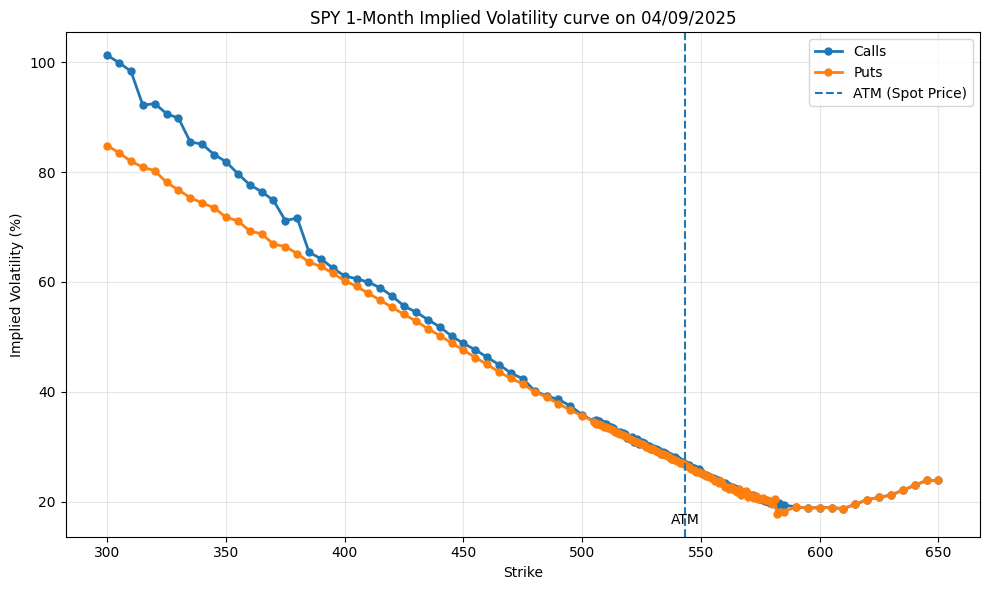

In [30]:
# Compute relative IV deviation
df_cp['iv_deviation'] = (df_cp['call_iv'] - df_cp['put_iv']).abs() / df_cp['put_iv']

# Keep only rows where deviation <= 5%
df_cp_filtered = df_cp[df_cp['iv_deviation'] <= 0.05].copy()
df_cp_filtered

,price_strike,call_price,call_iv,put_price,put_iv,call_minus_put,iv_deviation
17,385.0,160.37000,0.654194,0.905,0.635942,159.46500,0.028701
18,390.0,155.47500,0.642198,1.020,0.628302,154.45500,0.022117
19,395.0,150.53500,0.625353,1.100,0.615938,149.43500,0.015286
20,400.0,145.62000,0.610674,1.175,0.602545,144.44500,0.013491
21,405.0,140.82999,0.606013,1.285,0.591762,139.54499,0.024082
...,...,...,...,...,...,...,...
135,630.0,0.10000,0.212019,86.295,0.212019,-86.19500,0.000000
136,635.0,0.08500,0.220893,91.295,0.220893,-91.21000,0.000000
137,640.0,0.08500,0.229767,96.295,0.229767,-96.21000,0.000000
138,645.0,0.09000,0.238642,101.295,0.238642,-101.20500,0.000000


In [31]:
spot_price = list(set(df_option_data['underlying_price']))[0] 
option_start_date = "2025-04-09"
option_end_date = "2025-05-09"
time_to_maturity = 30/365
start = pd.to_datetime(option_start_date)
end = pd.to_datetime(option_end_date)


In [32]:
call_minus_put_col = 'call_minus_put'
strike_col = 'price_strike'
estimate_q_r_from_options(df_cp_filtered, call_minus_put_col, strike_col, spot_price, time_to_maturity)

{'q': np.float64(-0.060693477134874545),
 'r': np.float64(-0.031764483572459555),
 'PVF': np.float64(546.0873761325169),
 'disc': np.float64(1.00261419052429),
 'rmse': np.float64(0.296845339943721)}

# <u>Conclusion on using OLS to find risk free (r) and dividend rate (q)</u>

After the performing OLS etimation of risk free rate (r) and dividend rate (q) in Black Scholes from April 09 Options market data:
- **Estimated Dividend Rate(q)**: -6.07%
- **Estimatated Risk Free Rate (r)**: -3.18%

We can see that the estimated dividend rate and risk free rate contradicts the actual market situation of that day where actual risk free rate is around ~4.33% from the 1 Month Treasuery Yield on April 09 2025 and dividend rate of SPY is around ~1.27%.

This could be due to reasons like the extreme rallies on April 09 causing the put–call parity relationship to deviate due to temporary order-flow imbalances, widened bid–ask spreads, volatility shocks, and liquidity distortions leading the regression to infer unrealistic negative values for the risk-free rate and dividend yield.

Therefore we will stick to the actual risk free rate and dividend rate as of that day in the future scenario analysis.